# Baseline
Setting up a more robust baseline notebook, suitable for use with all of the "Big Three" (XGBoost, CatBoost, LightGBM) libraries and on either Google Colab or the local machine.

## 20211017
Implementing post-split encoding of non-binary categorical features (with cardinality <100k, but >2) using WOEEncoder on the BorutaShap generated 136-feature dataset. Encoder is fit on the training partition, and that fitted encoder is then deployed on the validation and test partitions.

# Setup

In [1]:
# two manual flags (ex-config)
COLAB = False
USE_GPU = True
libraries = ['xgboost', 'lightgbm', 'catboost', 'widedeep-SAINT']

In [2]:
# basic imports
from pathlib import Path
import os
import math
from datetime import datetime
import random

In [3]:
%matplotlib inline
%config Completer.use_jedi = False
os.environ['WANDB_NOTEBOOK_NAME'] = f"stacking_manual_{datetime.now().strftime('%Y%m%d')}.ipynb"

In [4]:
# handle Google Colab-specific library installation/updating
if COLAB:
    # much of the below inspired by or cribbed from the May 2021 Kaggle Tabular Playground winner, at 
    # https://colab.research.google.com/gist/academicsuspect/0aac7bd6e506f5f70295bfc9a3dc2250/tabular-may-baseline.ipynb?authuser=1#scrollTo=LJoVKJb5wN0L
    
    # Kaggle API for downloading the datasets
#     !pip install --upgrade -q kaggle

    # weights and biases
    !pip install -qqqU wandb
    
    # Optuna for parameter search
    !pip install -q optuna

    # upgrade sklearn
    !pip install --upgrade scikit-learn

#     !pip install category_encoders
    
    if 'catboost' in libraries:
        !pip install catboost
    
    if 'xgboost' in libraries:
        if USE_GPU: 
            # this part is from https://github.com/rapidsai/gputreeshap/issues/24
            !pip install cmake --upgrade
            # !pip install sklearn --upgrade
            !git clone --recursive https://github.com/dmlc/xgboost
            %cd /content/xgboost
            !mkdir build
            %cd build
            !cmake .. -DUSE_CUDA=ON
            !make -j4
            %cd /content/xgboost/python-package
            !python setup.py install --use-cuda --use-nccl
            !/opt/bin/nvidia-smi
            !pip install shap
        else:
            !pip install --upgrade xgboost
    if 'lightgbm' in libraries:
        if USE_GPU:
            # lighgbm gpu compatible
            !git clone --recursive https://github.com/Microsoft/LightGBM
            ! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;
        else:
            !pip install --upgrade lightgbm
        

        

Now, non-stdlib imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# general ML tooling
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import log_loss, roc_auc_score
import wandb
from wandb.xgboost import wandb_callback
from wandb.lightgbm import wandb_callback
from sklearn.impute import SimpleImputer #, KNNImputer
# import timm

import seaborn as sns

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler #, MinMaxScaler, MaxAbsScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import SelectKBest, f_regression
from joblib import dump, load
# feature engineering tools
# from sklearn.feature_selection import mutual_info_regression
# import featuretools as ft

from BorutaShap import BorutaShap

In [6]:
from pytorch_widedeep import Trainer
from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
from pytorch_widedeep.models import Wide, TabMlp, WideDeep, SAINT, TabTransformer, TabNet, TabFastFormer, TabResnet
from pytorch_widedeep.metrics import Accuracy
from torchmetrics import AUROC
import torch
from torch.optim import Adam, AdamW, Adagrad, SGD, RMSprop, LBFGS
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, CyclicLR, OneCycleLR, StepLR, CosineAnnealingLR
from pytorch_widedeep.callbacks import EarlyStopping, LRHistory, ModelCheckpoint

In [7]:
import category_encoders as ce

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working


Now, datapath setup

In [8]:
# # This is the code for reading the train.csv and converting it to a .feather file
# df = pd.read_csv(datapath/'train.csv', index_col='id', low_memory=False)
# df.index.name = None
# df.to_feather(path='./dataset_df.feather')

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [9]:
if COLAB:
    # mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    # handling datapath
    datapath = Path('/content/drive/MyDrive/kaggle/tabular_playgrounds/oct2021/')
    
else:
    # if on local machine
#     datapath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/sep2021/')  
    root = Path('/home/sf/code/kaggle/tabular_playgrounds/oct2021/')
    datapath = root/'datasets'
    edapath = root/'EDA'
    modelpath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/oct2021/models/')
    predpath = root/'preds'
    subpath = root/'submissions'
    altdatapath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/oct2021/alt_datasets/')
    
    for pth in [root, datapath, edapath, modelpath, predpath, subpath]:
        pth.mkdir(exist_ok=True)
    


In [10]:
SEED = 42

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(seed=SEED)

## Ex-Model Config

In [11]:
# meta-config for preprocessing and cross-validation, but NOT for model parameters
exmodel_config = {
#     "feature_selector": SelectKBest,
#     "k_best": 80,
#     "feature_selection_scoring": f_regression,
#     'random_state': SEED,
#     'feature_generation': ['NaN_counts', 'SummaryStats', 'NaN_OneHots'],
#     'subsample': 1,
    'cross_val_strategy': KFold, # None for holdout, or the relevant sklearn class
    'kfolds': 5, # if 1, that means just doing holdout
    'test_size': 0.2,
#     'features_created': False,
#     'feature_creator': None,
}

## Data Setup

**TODO** Write some conditional logic here to automate it -- possibly as part of a sklearn.*pipeline

In [12]:
# if exmodel_config['scaler']:
#     scaler = exmodel_config['scaler']()
#     scaler.fit_transform()

In [13]:
# test_source = datapath/'test.feather'
test_source = altdatapath/'X_test_boruta_shap_200trials.feather'
exmodel_config['test_source'] = str(test_source)
X_test = pd.read_feather(path=test_source)
# boruta = load(altdatapath/'boruta_shap.joblib')
# X_test_enc = 
# X_test = X_test.iloc[:, 1:] # only if loading the original test

In [14]:
X_test.shape

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


(500000, 136)

In [15]:
X_test.head()

,f174,f72,f265,f44,f53,f62,f16,f206,f74,f33,...,f201,f113,f134,f269,f245,f95,f227,f125,f99,f164
0,0.012371,0.007640,1,0.140470,0.182717,0.527465,0.326189,0.012927,0.232048,0.033877,...,0.162079,0.084567,0.223034,1,0,0.150668,0.004668,0.004237,0.113824,0.091122
1,0.010584,0.005635,0,0.816747,0.179046,0.403958,0.345882,0.011735,0.207006,0.040739,...,0.346100,0.083794,0.223926,0,1,0.149731,0.005358,0.005642,0.111823,0.089819
2,0.004733,0.006748,1,0.839762,0.205801,0.712239,0.531088,0.015955,0.269181,0.040174,...,0.159611,0.084738,0.224098,0,1,0.148467,0.008697,0.008542,0.113983,0.164486
3,0.332225,0.003166,0,0.836255,0.210587,0.528602,0.332168,0.014845,0.211222,0.312709,...,0.163853,0.084472,0.223098,1,0,0.149700,0.008606,0.008843,0.112732,0.088619
4,0.004208,0.007184,0,0.824412,0.191561,0.672381,0.427928,0.375914,0.208308,0.037337,...,0.165464,0.166353,0.224409,1,1,0.146919,0.002766,0.006053,0.113022,0.174795


In [16]:
# train_source = altdatapath/'X_orig.feather'
train_source = altdatapath/'X_boruta_shap_200trials.feather'
X = pd.read_feather(path=train_source)
# df.index.name = 'id'
# y = np.array(df.target)
y = load(datapath/'y.joblib')
# features = [x for x in df.columns if x != 'target']
# X = df[features] # passing X as a pd.DataFrame to the trainer below, rather than as an np.ndarray
# X_train = df[features]
# X.index.name = 'id'
# y.index.name = 'id'


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [17]:
# X.columns

In [18]:
# X_test = X_test[X.columns]

In [19]:
# X_test.to_feather(altdatapath/'X_test_boruta_shap.feather')

In [20]:
categoricals = [f for f in X.columns if ((1000000 - X[f].nunique()) / 1000000) >= 0.9 and X[f].nunique() > 2]

In [21]:
# encoder = ce.WOEEncoder(cols=categoricals)
# encoder.fit(X,y)
# X_enc = encoder.transform(X)

In [22]:
# X_train.columns

In [23]:
# wide_cols = [f for f in X_train.columns if X_train[f].nunique() == 2]

In [24]:
# wide_cols

In [25]:
# X_train.shape

In [26]:
# X = np.array(X_train)
# y = np.array(y_train)

# del df, X_train, y_train

# encoder = ce.WOEEncoder(cols=categoricals)
# encoder.fit(X,y)
# X_enc = encoder.transform(X)
# # exmodel_config['feature_count'] = len(X.columns)
# exmodel_config['feature_count'] = X_enc.shape[1]
# exmodel_config['instance_count'] = X_enc.shape[0]
# exmodel_config['encoder'] = str(encoder)
# exmodel_config['feature_generator'] = None
# exmodel_config['feature_generator'] = "Summary statistics"

exmodel_config['train_source'] = str(train_source)

In [27]:
# X_df = pd.DataFrame(X)

In [28]:
# print(X_df.iloc[:,0])

In [29]:
# print(X_df.iloc[:, list(X_df.columns)[0]])

In [30]:
# X_test_enc = encoder.transform(X_test.iloc[:, 1:]) # if going from original dataset

# X_test_enc = encoder.transform(X_test)

In [31]:
# X_test_enc.shape

In [32]:
# X_test_enc.head()

In [33]:
# X_test = np.array(X_test)

## Weights and Biases Run Config

Below is the configuration for a Weights and Biases (`wandb`) run.

In [34]:
# wandb config:
wandb_config = {
    'name': f"{os.environ['WANDB_NOTEBOOK_NAME'][:-6]}_{datetime.now().strftime('%H%M%S')}", # just removes the .ipynb extension, leaving the notebook filename's stem
    'tags': ['category-encoder', 'stacking'],
    'notes': "Trying the GBM ensemble stack with CatBoostEncoder from category_encoders, on Boruta-SHAP dataset",
}

# Training

# Hyperparameters

In [35]:
# optuna 20211004, thru 106 trials on unaltered original dataset
best_xgboost_params = {
    'n_estimators': 3878,
    'max_depth': 4,
    'learning_rate': 0.024785857161974977,
    'reg_alpha': 26.867682044658245,
    'reg_lambda': 10.839759074147148,
    'subsample': 0.8208581489835881,
    'min_child_weight': 8.829122644339664,
    'colsample_bytree': 0.906420714280384,
    'gamma': 1.472322916021486
}

# best as of 20211005, thru 65 trials on unaltered original dataset
best_lightgbm_params = {
    'n_estimators': 6631,
    'max_depth': 10,
    'learning_rate': 0.004677044539666842,
    'reg_alpha': 19.334971246299116,
    'reg_lambda': 0.024384251140153856,
    'subsample': 0.5082183652689569,
    'boosting_type': 'gbdt',
    'min_child_samples': 9,
    'num_leaves': 233,
    'colsample_bytree': 0.5008014086989773
}

# catboost 20211001 on colab with 100 trials on GPU, unaltered original dataset
best_catboost_params = {
    'iterations': 29338,
    'max_depth': 9,
    'learning_rate': 0.004769831650275205,
    'random_strength': 7,
    'od_wait': 1968,
    'reg_lambda': 28.435563240493586,
    'border_count': 162,
    'min_child_samples': 14,
    'leaf_estimation_iterations': 1
}

# initial, non-default guess -- need to get optuna working (20211010)
# basic_widedeep_tabmlp_params = {
    
# }

# basic_widedeep_trainer_params = {
#     optimizers=AdamW()
# }

In [145]:
from lightgbm.basic import LightGBMError

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# Cross-Validator


In [104]:
def cross_validate_model(library:str, params:dict={}, X=X, y=y, X_test=X_test, start_fold=0, 
                         exmodel_config=exmodel_config, wandb_config=wandb_config, 
                         random_state=42, shuffle_kfolds=True, wandb_tracked=True, encode_cats=True, try_lgb_gpu=False):
    """
    Function to handle model training process in the context of cross-validation -- via hold-out or via k-fold.
    If exmodel_config['cross_val_strategy'] == None, then any kfolds= input is ignored; otherwise, the number specified is used.
    
    :param kfolds: int specifying number of k-folds to use in cross-validation
    :param exmodel_config: dict containing general config including for cross-validation -- `kfold=1` implies hold-out
    """
#     if exmodel_config['kfolds'] == 1:
#         print("Proceeding with holdout")
#     X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
#                                                           test_size=0.2, 
#                                                           random_state=SEED)                 
    
    # prepare for k-fold cross-validation; random-state here is notebook-wide, not per-model
    # shuffle on the initial sets, but not subsequently -- performing the same operation twice means a very different dataset
    if shuffle_kfolds:
        kfold = exmodel_config['cross_val_strategy'](n_splits=exmodel_config['kfolds'], shuffle=True, random_state=SEED)
    else:
        kfold = exmodel_config['cross_val_strategy'](n_splits=exmodel_config['kfolds'], shuffle=False)
    
    if wandb_tracked:
        exmodel_config['library'] = library
        exmodel_config[f'{library}_params'] = str(params)
        wandb.init(
            project="202110_Kaggle_tabular_playground",
            save_code=True,
            tags=wandb_config['tags'],
            name=wandb_config['name'],
            notes=wandb_config['notes'],
            config=exmodel_config
    )   
    
    # setup for serialization
    runpath = Path(modelpath/f"{wandb_config['name']}_{library}_{exmodel_config['kfolds']}folds/")
    (runpath).mkdir(exist_ok=True)
    
    
    # initialize lists for out-of-fold preds and ground truth
    oof_preds, oof_y = [], []
    
    # initialize a numpy.ndarray containing the fold-model's preds for test set
    test_preds = np.zeros((X_test.shape[0]))
    
    # if using deep learning with pytorch-widedeep, do data preprocessing now, before splits
    if 'widedeep' in library:
        # NOTE THAT ENCODING NOT DEPLOYED FOR THIS YET
        # preprocessing first
        wide_cols = [f for f in X.columns if X[f].nunique() == 2] #list(X_train.columns) if X_train.iloc[:,f].nunique() == 2] # binary indicator vars are wide
        cont_cols = [f for f in X.columns if X[f].nunique() > 2] #list(X_train.columns) if X_train.iloc[:,f].nunique() > 2] # others are cont

        # wide part
        wide_preprocessor = WidePreprocessor(wide_cols=wide_cols)
        X_wide = wide_preprocessor.fit_transform(X)
#         print(f"X_wide.shape = {X_wide.shape}")
#         X_wide = np.array(X_train[wide_cols])
        

        # deep part
        tab_preprocessor = TabPreprocessor(continuous_cols=cont_cols)#, embed_cols=embed_cols, )
        X_tab = tab_preprocessor.fit_transform(X)   
#         print(f"X_tab.shape = {X_tab.shape}")
        
        # transforming the test set
        X_test_wide = wide_preprocessor.transform(X_test)
        X_test_tab = tab_preprocessor.transform(X_test)
        
        # at this point, X_wide, X_tab, X_test_wide, and X_test_tab will all be np.ndarrays
    
#     else: # if using a GBM, simply convert the pd.DataFrames to np.ndarrays
#         X = np.array(X) # CAN YOU USE CATEGORY_ENCODERS ON NP.NDARRAYS?
#         X_test = np.array(X_test)
    
    for fold, (train_ids, valid_ids) in enumerate(kfold.split(X,y)):
#         print(f"type(train_ids) = {type(train_ids)} and train_ids.shape = {train_ids.shape}")
#         print(f"type(valid_ids) = {type(valid_ids)} and train_ids.shape = {valid_ids.shape}")
        if fold < start_fold: # skip folds that are already trained
            continue
        else:
            print(f"FOLD {fold}")
            print("---------------------------------------------------")
            y_train, y_valid = y[train_ids], y[valid_ids] # y will be an np.ndarray already; handling will be same regardless of model
            if 'widedeep' in library: # handle wide and deep tabs in parallel
                X_train_wide, X_valid_wide = X_wide[train_ids, :], X_wide[valid_ids, :]
                X_train_tab, X_valid_tab = X_tab[train_ids, :], X_tab[valid_ids, :]
#                 print(f"X_train_wide.shape = {X_train_wide.shape}")
#                 print(f"X_train_tab.shape = {X_train_tab.shape}")
#                 print(f"X_test_wide.shape = {X_test_wide.shape}")
#                 print(f"X_test_tab.shape = {X_test_tab.shape}")
            else: # handle datasets for GBMs
                if isinstance(X, np.ndarray):
                    X_train, X_valid = X[train_ids], X[valid_ids]
                else:
                    X_train, X_valid = X.iloc[train_ids,:], X.iloc[valid_ids,:] # bc need pandas.DataFrames for ce
                if encode_cats:
                    encoder = ce.WOEEncoder(cols=categoricals)
                    encoder.fit(X_train,y_train)
                    X_train = encoder.transform(X_train)
                    X_valid = encoder.transform(X_valid)
                # exmodel_config['feature_count'] = len(X.columns)
                    wandb.log({
                        'feature_count': X_train.shape[1],
                        'instance_count': X_train.shape[0],
                        'encoder': str(encoder)
                    })
#                 exmodel_config['instance_count'] = X_train.shape[0]
#                 exmodel_config['encoder'] = str(encoder)
                    X_test = encoder.transform(X_test)
#                 y_train, y_valid = y[train_ids], y[valid_ids]
            
        # define models
        if library == 'xgboost':
            model = XGBClassifier(
                booster='gbtree',
                tree_method='gpu_hist',
                random_state=random_state,
                n_jobs=-1, 
                verbosity=1, 
                objective='binary:logistic',
                **params)
            if wandb_tracked:
                model.fit(X_train, y_train, callbacks=[wandb.xgboost.wandb_callback()])
            else:
                model.fit(X_train, y_train)
            y_valid_preds = model.predict_proba(X_valid)[:,1]
            
            # add the fold-model's OOF preds and ground truths to the out-of-loop lists
            oof_preds.extend(y_valid_preds)
            oof_y.extend(y_valid)
            
            # add the fold's predictions to the model's test-set predictions (will divide later)
            test_preds += model.predict_proba(X_test)[:,1]


        elif library == 'lightgbm':
            try:
                model = LGBMClassifier(
                    objective='binary',
                    random_state=random_state,
                    device_type='cpu',
                    n_jobs=-1,
    #                 eval_metric='auc',
                    device_type='gpu',
                    max_bin=63, # 15 might be even better for GPU perf, but depends on dataset -- see https://lightgbm.readthedocs.io/en/latest/GPU-Performance.html
    #                 gpu_use_dp=False, # forces use of single precision rather than double for better perf, esp on consumer Nvidia chips
                    **params)
                
                if wandb_tracked:
                    model.fit(X_train, y_train, callbacks=[wandb.lightgbm.wandb_callback()],)
                else:
                    model.fit(X_train, y_train)
            except LightGBMError:
                model = LGBMClassifier(
                    objective='binary',
                    random_state=random_state,
                    device_type='cpu',
                    n_jobs=-1,
    #                 eval_metric='auc',
    #                 device_type='gpu',
    #                 max_bin=63, # 15 might be even better for GPU perf, but depends on dataset -- see https://lightgbm.readthedocs.io/en/latest/GPU-Performance.html
    #                 gpu_use_dp=False, # forces use of single precision rather than double for better perf, esp on consumer Nvidia chips
                    **params)
                
                if wandb_tracked:
                    model.fit(X_train, y_train, callbacks=[wandb.lightgbm.wandb_callback()],)
                else:
                    model.fit(X_train, y_train)
            y_valid_preds = model.predict_proba(X_valid)[:,1]
            
            # add the fold-model's OOF preds and ground truths to the out-of-loop lists
            oof_preds.extend(y_valid_preds)
            oof_y.extend(y_valid)
            
            # add the fold's predictions to the model's test-set predictions (will divide later)
            test_preds += model.predict_proba(X_test)[:,1]

            
        elif library == 'catboost':
            model = CatBoostClassifier(
                task_type='GPU',
                silent=True,
                random_state=random_state,
                **params) 
        
            model.fit(X_train, y_train)
            y_valid_preds = model.predict_proba(X_valid)[:,1]
            
            # add the fold-model's OOF preds and ground truths to the out-of-loop lists
            oof_preds.extend(y_valid_preds)
            oof_y.extend(y_valid)
            
            # add the fold's predictions to the model's test-set predictions (will divide later)
            test_preds += model.predict_proba(X_test)[:,1]
            
        elif 'widedeep' in library: # only coding for TabMlp right now
#             X_train = pd.DataFrame(X_train, columns=[f"f{x}" for x in range(X_train.shape[1])])
#             X_valid = pd.DataFrame(X_valid, columns=[f"f{x}" for x in range(X_valid.shape[1])])
#             X_test = pd.DataFrame(X_test, columns=[f"f{x}" for x in range(X_test.shape[1])])
            
            wide = Wide(wide_dim=np.unique(X_wide).shape[0], pred_dim=1)
#             deeptabular = TabMlp(
#                 mlp_hidden_dims=[64,32],
#                 column_idx=tab_preprocessor.column_idx,
#             #     embed_input=tab_preprocessor.embeddings_input,
#                 continuous_cols=cont_cols,
#             )
            deeptabular = SAINT(
                column_idx=tab_preprocessor.column_idx,
                continuous_cols=cont_cols,
            )
            
            # model instantiation and training
            model = WideDeep(wide=wide, deeptabular=deeptabular)
            
            
            n_epochs = 30

            # pytorch hyperparams
            wide_opt = AdamW(model.wide.parameters(), lr=0.1)
            deep_opt = AdamW(model.deeptabular.parameters(), lr=0.1)
            
#             wide_sch = ReduceLROnPlateau(wide_opt)
#             deep_sch = ReduceLROnPlateau(deep_opt)

            wide_sch = OneCycleLR(optimizer=wide_opt, max_lr=0.01, steps_per_epoch=X_train_wide.shape[0], epochs=n_epochs)
            deep_sch = OneCycleLR(optimizer=deep_opt, max_lr=0.01, steps_per_epoch=X_train_tab.shape[0], epochs=n_epochs)
            
            optimizers = {'wide': wide_opt, 'deeptabular': deep_opt }
            lr_schedulers = {'wide': wide_sch, 'deeptabular': deep_sch }
            
            
            callbacks = [
                LRHistory(n_epochs=n_epochs), 
#                 EarlyStopping, 
#                 ModelCheckpoint(
#                     filepath='',
#                     save_best_only=True
#                 )
            ]
            
            # trainer
            trainer = Trainer(model=model, 
                              objective='binary', 
                              metrics=[Accuracy], # with AUROC got TypeError: '>' not supported between instances of 'NoneType' and 'int' 
                              seed=random_state, 
#                               lr_schedulers=lr_schedulers,
                              optimizers=optimizers,
                              callbacks=callbacks
                             )
            
#             print(f"type(X_train_wide) is {type(X_train_wide)} and type(X_train_tab) is {type(X_train_tab)}")
            trainer.fit( # this is where problem is beginning
                X_wide=X_train_wide,
                X_tab=X_train_tab,
                target=y_train,
                n_epochs=n_epochs,
                batch_size=1024, # default value is 32
#                 val_split=0.2, # no need for this
            )
            
            # validation set preprocessing
#             X_valid_wide = np.array(X_valid[wide_cols]) # wide_preprocessor.transform(X_valid)
#             X_tab_valid = tab_preprocessor.transform(X_valid)
#             print(f"X_valid_wide: {X_valid_wide[:10]}")
#             print(f"X_valid_tab: {X_valid_tab[:10]}")
            y_valid_preds = trainer.predict_proba(X_wide=X_valid_wide, X_tab=X_valid_tab, batch_size=1024)[:,1]
            
            # add the fold-model's OOF preds and ground truths to the out-of-loop lists
            oof_preds.extend(y_valid_preds)
            oof_y.extend(y_valid)
            
            # test set preprocessing
#             X_test_wide = np.array(X_test[wide_cols]) # wide_preprocessor.transform(X_test)
#             X_tab_test = tab_preprocessor.transform(X_test)
#             print(f"X_test_wide: {X_test_wide[:10]}")
#             print(f"X_test_tab: {X_test_tab[:10]}")
            
            # test set inference
            fold_test_preds = trainer.predict_proba(X_wide=X_test_wide, X_tab=X_test_tab, batch_size=1024)[:,1]
            test_preds += fold_test_preds
#             print(f"fold_test_preds: {fold_test_preds[:10]}")
#             print(f"test_preds_so_far: {test_preds[:10]}")
            
        # take the training set predictions, if desired
#         y_train_pred = model.predict_proba(X_train)[:,1]
#         train_loss = log_loss(y_train, y_train_pred)
#         train_auc = roc_auc_score(y_train, y_train_pred)
#         wandb.log({'train_loss': train_loss, 'train_auc': train_auc})

        # log the parameters, if desired
#         if exmodel_config['library'] == 'catboost':
#             print(model.get_all_params())
#             wandb.log(model.get_all_params())
#         else:
#             wandb.log(model.get_params()) # logging model parameters, trying bare-invocation rather than params: model.get_params()

        
        
       
        
        

#         valid_loss = log_loss(y_valid, y_pred)
        # give the valid AUC score, for edification
        fold_valid_auc = roc_auc_score(y_valid, y_valid_preds)
        print(f"Valid AUC for fold {fold} is {fold_valid_auc}")   
        dump(model, Path(runpath/f"{library}_fold{fold}_rs{random_state}_model.joblib"))

    model_valid_auc = roc_auc_score(oof_y, oof_preds)
    print(f"Valid AUC score for {library} model is {model_valid_auc}")
    
    # finalize test preds
    test_preds /= exmodel_config['kfolds']
    
    # save OOF preds and test-set preds
    dump(oof_preds, Path(predpath/f"{wandb_config['name']}_{library}_{exmodel_config['kfolds']}folds_rs{random_state}_oof_preds.joblib"))
    dump(test_preds, Path(predpath/f"{wandb_config['name']}_{library}_{exmodel_config['kfolds']}folds_rs{random_state}_test_preds.joblib"))
    dump(oof_y, predpath/f"{exmodel_config['kfolds']}folds_rs{SEED}_oof_y.joblib")
    
    if wandb_tracked:
#         if 'widedeep' in library:
        wandb.log({'model_valid_auc': model_valid_auc,
#                    'oof_preds': oof_preds,
#                    'test_preds': test_preds,
                   'model_params': str(model.parameters()) if 'widedeep' in library else str(model.get_params()), 
        #                    'model_params': str(model.get_params()),
        })
#         wandb.log({'model_valid_auc': model_valid_auc,
#                    'oof_preds': oof_preds,
#                    'test_preds': test_preds,
# #                    'model_params': str(model.get_params()),
#                   })
        wandb.finish()
    return oof_preds, test_preds
        

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [37]:
# _, lightgbm_preds = cross_validate_model(library='lightgbm')

In [38]:
# _, catboost_preds = cross_validate_model(library='catboost')

In [39]:
# xgboost_oof_preds, xgboost_test_preds = cross_validate_model(library='xgboost')

In [40]:
# widedeep_oof_preds, widedeep_test_preds = cross_validate_model(library='widedeep-SAINT', wandb_tracked=True)

In [41]:
# widedeep_oof_preds = load(predpath/f"{wandb_config['name']}_widedeep-TabMLP_{exmodel_config['kfolds']}folds_rs{42}_oof_preds.joblib")

In [42]:
# widedeep_test_preds = load(predpath/f"{wandb_config['name']}_widedeep-TabMLP_{exmodel_config['kfolds']}folds_rs{42}_test_preds.joblib")

In [43]:
# widedeep_oof_preds[:10]

In [44]:
# widedeep_test_preds[:10]

# Single Submission

In [45]:
# sample_df = pd.read_csv(datapath/'sample_submission.csv.zip')

In [46]:
# sample_df.loc[:, 'target'] = widedeep_test_preds

In [47]:
# sample_df.iloc[:20]

In [48]:
# submission_path = datapath/'submissions'
# submission_path.mkdir(exist_ok=True)

In [49]:
# sample_df.to_csv(subpath/f"{wandb_config['name']}_widedeep-TabMLP-upto50epochs-64x32_{exmodel_config['kfolds']}folds_rs{42}_baseline_preds.csv", index=False)

In [50]:
# str(blender.estimators[2][1].get_all_params())
# blender.estimators[2][1]

In [51]:
# wandb.log({'leaderboard_auc': 0.81725,
# #            'catboost_params': str(best_catboost_params),
#           })

In [52]:
# wandb.finish()

In [53]:
# oof_y_pd = pd.Series(oof_y)

# Predictions

## Level One

In [60]:
oof_lv1, test_lv1 = pd.DataFrame(), pd.DataFrame() # initialize dataframes

### Generating

In [61]:
oof_lv1_lgb42, test_lv1_lgb42 = cross_validate_model(library='lightgbm', X=X, y=y, X_test=X_test, 
                                         wandb_config=wandb_config,
                                         random_state=42,
                                         params=best_lightgbm_params,
                                         exmodel_config=exmodel_config, 
                                         wandb_tracked=True
                                        )
oof_lv1['lgb42'] = oof_lv1_lgb42
test_lv1['lgb42'] = test_lv1_lgb42

wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


FOLD 0
---------------------------------------------------
Valid AUC for fold 0 is 0.816058639291391
FOLD 1
---------------------------------------------------
Valid AUC for fold 1 is 0.8164791225170542
FOLD 2
---------------------------------------------------
Valid AUC for fold 2 is 0.8161435642202157
FOLD 3
---------------------------------------------------
Valid AUC for fold 3 is 0.8157767707092227
FOLD 4
---------------------------------------------------
Valid AUC for fold 4 is 0.8162862052449575
Valid AUC score for lightgbm model is 0.816147468541153


feature_count,▁▁▁▁▁
instance_count,▁▁▁▁▁
model_valid_auc,▁
encoder,WOEEncoder(cols=['f1...
feature_count,136
instance_count,800000
model_params,{'boosting_type': 'g...
model_valid_auc,0.81615


In [62]:
oof_lv1_lgb1983, test_lv1_lgb1983 = cross_validate_model(library='lightgbm', X=X, y=y, X_test=X_test, 
                                                 wandb_config=wandb_config,
                                                 random_state=1983,
                                                 params=best_lightgbm_params,
                                                 exmodel_config=exmodel_config, 
                                                 wandb_tracked=True
                                                )
oof_lv1['lgb1983'] = oof_lv1_lgb1983
test_lv1['lgb1983'] = test_lv1_lgb1983

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


FOLD 0
---------------------------------------------------
Valid AUC for fold 0 is 0.8160255384908316
FOLD 1
---------------------------------------------------
Valid AUC for fold 1 is 0.8163473092924765
FOLD 2
---------------------------------------------------
Valid AUC for fold 2 is 0.8165844690616553
FOLD 3
---------------------------------------------------
Valid AUC for fold 3 is 0.8157233022372754
FOLD 4
---------------------------------------------------
Valid AUC for fold 4 is 0.816189244710383
Valid AUC score for lightgbm model is 0.8161728533450376


feature_count,▁▁▁▁▁
instance_count,▁▁▁▁▁
model_valid_auc,▁
encoder,WOEEncoder(cols=['f1...
feature_count,136
instance_count,800000
model_params,{'boosting_type': 'g...
model_valid_auc,0.81617


In [63]:
oof_lv1_xgb42, test_lv1_xgb42 = cross_validate_model(library='xgboost', X=X, y=y, X_test=X_test, 
                                         wandb_config=wandb_config,
                                         random_state=42,
                                         params=best_xgboost_params,
                                         exmodel_config=exmodel_config, 
                                         wandb_tracked=True
                                        )

oof_lv1['xgb42'] = oof_lv1_xgb42
test_lv1['xgb42'] = test_lv1_xgb42

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


FOLD 0
---------------------------------------------------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


Valid AUC for fold 0 is 0.8170882988087922
FOLD 1
---------------------------------------------------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


Valid AUC for fold 1 is 0.8174623673975838
FOLD 2
---------------------------------------------------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


Valid AUC for fold 2 is 0.8171851843406069
FOLD 3
---------------------------------------------------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


Valid AUC for fold 3 is 0.8165420825390263
FOLD 4
---------------------------------------------------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


Valid AUC for fold 4 is 0.8173147633521343
Valid AUC score for xgboost model is 0.8171184766007747


feature_count,▁▁▁▁▁
instance_count,▁▁▁▁▁
model_valid_auc,▁
encoder,WOEEncoder(cols=['f1...
feature_count,136
instance_count,800000
model_params,{'objective': 'binar...
model_valid_auc,0.81712


In [64]:
oof_lv1_xgb1983, test_lv1_xgb1983 = cross_validate_model(library='xgboost', X=X, y=y, X_test=X_test, 
                                                 wandb_config=wandb_config,
                                                 random_state=1983,
                                                 params=best_xgboost_params,
                                                 exmodel_config=exmodel_config, 
                                                 wandb_tracked=True
                                                )
oof_lv1['xgb1983'] = oof_lv1_xgb1983
test_lv1['xgb1983'] = test_lv1_xgb1983

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


FOLD 0
---------------------------------------------------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


Valid AUC for fold 0 is 0.8168992496555972
FOLD 1
---------------------------------------------------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


Valid AUC for fold 1 is 0.8174651887759354
FOLD 2
---------------------------------------------------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


Valid AUC for fold 2 is 0.8172179530585512
FOLD 3
---------------------------------------------------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


Valid AUC for fold 3 is 0.8165066452413419
FOLD 4
---------------------------------------------------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


Valid AUC for fold 4 is 0.8173985803557999
Valid AUC score for xgboost model is 0.8170975569490914


feature_count,▁▁▁▁▁
instance_count,▁▁▁▁▁
model_valid_auc,▁
encoder,WOEEncoder(cols=['f1...
feature_count,136
instance_count,800000
model_params,{'objective': 'binar...
model_valid_auc,0.8171


In [65]:
oof_lv1_cat42, test_lv1_cat42 = cross_validate_model(library='catboost', X=X, y=y, X_test=X_test, 
                                         wandb_config=wandb_config,
                                         random_state=42,
                                         params=best_catboost_params,
                                         exmodel_config=exmodel_config, 
                                         wandb_tracked=True
                                        )
oof_lv1['cat42'] = oof_lv1_cat42
test_lv1['cat42'] = test_lv1_cat42

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


FOLD 0
---------------------------------------------------
Valid AUC for fold 0 is 0.8211630926776562
FOLD 1
---------------------------------------------------
Valid AUC for fold 1 is 0.8214464001327304
FOLD 2
---------------------------------------------------
Valid AUC for fold 2 is 0.820021095543552
FOLD 3
---------------------------------------------------
Valid AUC for fold 3 is 0.8193460595120576
FOLD 4
---------------------------------------------------
Valid AUC for fold 4 is 0.8207590592097669
Valid AUC score for catboost model is 0.8205466576523501


feature_count,▁▁▁▁▁
instance_count,▁▁▁▁▁
model_valid_auc,▁
encoder,WOEEncoder(cols=['f1...
feature_count,136
instance_count,800000
model_params,{'iterations': 29338...
model_valid_auc,0.82055


In [66]:
oof_lv1_cat1983, test_lv1_cat1983 = cross_validate_model(library='catboost', X=X, y=y, X_test=X_test, 
                                                 wandb_config=wandb_config,
                                                 random_state=1983,
                                                 params=best_catboost_params,
                                                 exmodel_config=exmodel_config, 
                                                 wandb_tracked=True
                                                )

oof_lv1['cat1983'] = oof_lv1_cat1983
test_lv1['cat1983'] = test_lv1_cat1983

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


FOLD 0
---------------------------------------------------
Valid AUC for fold 0 is 0.8211296713770915
FOLD 1
---------------------------------------------------
Valid AUC for fold 1 is 0.8212485668447234
FOLD 2
---------------------------------------------------
Valid AUC for fold 2 is 0.8208526173988933
FOLD 3
---------------------------------------------------
Valid AUC for fold 3 is 0.8194168710073416
FOLD 4
---------------------------------------------------
Valid AUC for fold 4 is 0.8211395568469744
Valid AUC score for catboost model is 0.8207563269496281


feature_count,▁▁▁▁▁
instance_count,▁▁▁▁▁
model_valid_auc,▁
encoder,WOEEncoder(cols=['f1...
feature_count,136
instance_count,800000
model_params,{'iterations': 29338...
model_valid_auc,0.82076


In [67]:
# this cell just for after-the-fact error corrections

# oof_lv1 = pd.DataFrame()
# test_lv1 = pd.DataFrame()

# oof_lv1['lgb1983'] = oof_lv1_lgb1983
# test_lv1['lgb1983'] = test_lv1_lgb1983
# oof_lv1['lgb42'] = oof_lv1_lgb42
# test_lv1['lgb42'] = test_lv1_lgb42
# oof_lv1['cat1983'] = oof_lv1_cat1983
# test_lv1['cat1983'] = test_lv1_cat1983
# oof_lv1['cat42'] = oof_lv1_cat42
# test_lv1['cat42'] = test_lv1_cat42
# oof_lv1['xgb1983'] = oof_lv1_xgb1983
# test_lv1['xgb1983'] = test_lv1_xgb1983
# oof_lv1['xgb42'] = oof_lv1_xgb42
# test_lv1['xgb42'] = test_lv1_xgb42



`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


### Loading Sets of Predictions

In [68]:
# oof_lv1, test_lv1 = pd.DataFrame(), pd.DataFrame()
# preds_path = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/sep2021/preds/')

In [69]:
# oof_lv1['xgb42'] = load(predpath/'stacking_manual_20211005_085253_xgboost_5folds_rs42_oof_preds.joblib')
# test_lv1['xgb42'] = load(preds_path/'stacking_manual_20210925_212129_xgboost_5folds_rs42_test_preds.joblib')

In [70]:
# oof_lv_xgb42_y = load(predpath/'stacking_manual_20211005_085253_xgboost_5folds_rs42_oof_y.joblib')

In [71]:
# roc_auc_score(y_true=oof_lv_xgb42_y, y_score=oof_lv1['xgb42'])

In [72]:
# oof_lv1['xgb1983'] = load(preds_path/'validAUC_0.8146252172737458_stacking_manual_20210926_211701_xgboost_5folds_rs1983_oof_preds.joblib')
# test_lv1['xgb1983'] = load(preds_path/'stacking_manual_20210926_211701_xgboost_5folds_rs1983_test_preds.joblib')

In [73]:
# oof_lv1['lgb42'] = load(preds_path/'validAUC_0.8156810521798477_stacking_manual_20210925_212129_lightgbm_5folds_rs42_oof_preds.joblib')
# test_lv1['lgb42'] = load(preds_path/'stacking_manual_20210925_212129_lightgbm_5folds_rs42_test_preds.joblib')

In [74]:
# oof_lv1['lgb1983'] = load(preds_path/'validAUC_0.8156503194185875_stacking_manual_20210925_212129_lightgbm_5folds_rs1983_oof_preds.joblib')
# test_lv1['lgb1983'] = load(preds_path/'stacking_manual_20210925_212129_lightgbm_5folds_rs1983_test_preds.joblib')

In [75]:
# oof_lv1['cat42'] = load(preds_path/'validAUC_0.8116727090290558_stacking_manual_20210925_212129_catboost_5folds_rs42_oof_preds.joblib')
# test_lv1['cat42'] = load(preds_path/'stacking_manual_20210925_212129_catboost_5folds_rs42_test_preds.joblib')

In [76]:
# oof_lv1['cat1983'] = load(predpath/'stacking_manual_20211005_085253_catboost_5folds_rs1983_oof_preds.joblib')
# oof_cat1983_y = load(predpath/'stacking_manual_20211005_085253_catboost_5folds_rs1983_oof_y.joblib')
# roc_auc_score(y_true=oof_cat1983_y, y_score=oof_lv1['cat1983'])
# test_lv1['cat1983'] = load(preds_path/'stacking_manual_20210925_212129_catboost_5folds_rs1983_test_preds.joblib')

In [77]:
# oof_cat42_y = load(predpath/'stacking_manual_20211005_085253_catboost_5folds_rs42_oof_y.joblib')

In [78]:
# oof_cat42_y == oof_lv_xgb42_y

In [79]:
# oof_lv1.iloc[:20, :]

In [80]:
# oof_y_pd.iloc[:20]

- Why is it that the random seed seems far more important than the model type in making a prediction???

### Serialization

In [81]:
# oof_lv1.head()

In [82]:
# test_lv1.head()

In [83]:
# oof_lv1.to_csv('oof_lv1.csv', index=False)
# test_lv1.to_csv('test_lv1.csv', index=False)

In [84]:
oof_lv1.to_feather(predpath/f"{wandb_config['name']}_X_BorutaShap_WOEEncoder_oof_lv1.feather")
test_lv1.to_feather(predpath/f"{wandb_config['name']}_X_BorutaShap_WOEEncoder_test_lv1.feather")

### Lv1 Finalization

In [85]:
# oof_lv1 = pd.read_feather(predpath/f"stacking_manual_20211005_205933_oof_lv1.feather")#, columns=[str(x) for x in range()])
# test_lv1 = pd.read_feather(predpath/f"stacking_manual_20211005_205933_test_lv1.feather")
oof_y = load(predpath/f"{exmodel_config['kfolds']}folds_rs{SEED}_oof_y.joblib")

In [86]:
oof_lv1.head()

,lgb42,lgb1983,xgb42,xgb1983,cat42,cat1983
0,0.478871,0.476259,0.529582,0.514049,0.464951,0.450981
1,0.975970,0.974758,0.967909,0.968054,0.976055,0.976681
2,0.958222,0.959417,0.967893,0.969249,0.965429,0.952667
3,0.197337,0.196504,0.182542,0.186844,0.169967,0.167794
4,0.044150,0.046064,0.041248,0.039237,0.034874,0.031862


In [87]:
test_lv1.head()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,lgb42,lgb1983,xgb42,xgb1983,cat42,cat1983
0,0.778917,0.783695,0.804150,0.798237,0.806537,0.818068
1,0.348133,0.352351,0.386135,0.397379,0.365545,0.371936
2,0.912121,0.914026,0.913147,0.912995,0.914974,0.914787
3,0.813371,0.813845,0.875267,0.877467,0.871601,0.871644
4,0.370489,0.365454,0.330845,0.319868,0.356576,0.360108


In [88]:
# oof_lv1['target'] = oof_y

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [89]:
# oof_lv1.iloc[:30,:]

In [90]:
# roc_auc_score(y_score=oof_lv1['lgb1983'], y_true=oof_y) # 0.5002913418201236 from original, bad version

**SO THERE'S SOMETHING WRONG WITH THE TARGET**

In [91]:
# def regenerate_targets(X=X_train, y=y_train):
#     kfold = exmodel_config['cross_val_strategy'](n_splits=exmodel_config['kfolds'], shuffle=True, random_state=SEED)
#     oof_y = []
#     for fold, (train_ids, valid_ids) in enumerate(kfold.split(X,y)):
# #         X_train, X_valid = X[train_ids], X[valid_ids]
#         y_train, y_valid = y[train_ids], y[valid_ids]
#         oof_y.extend(y_valid)
#     return oof_y

In [92]:
# oof_y_restored = regenerate_targets()

In [93]:
# oof_y[:20]

In [94]:
# oof_y_restored[:20]

In [95]:
# roc_auc_score(y_score=oof_lv1['lgb1983'], y_true=oof_y_restored) # 0.8564776078917813 from fixed version, via `regenerate_targets`

There we go

In [96]:
# dump(oof_y_restored, predpath/f"{exmodel_config['kfolds']}folds_rs{SEED}_oof_y.joblib")

In [97]:
# oof_lv1.index.name = 'id'
# test_lv1.index.name = 'id'
# oof_y.index.name = 'id'
oof_lv1 = np.array(oof_lv1)
test_lv1 = np.array(test_lv1)
oof_y = np.array(oof_y)

## Level Two

In [98]:
oof_lv2, test_lv2 = pd.DataFrame(), pd.DataFrame()

In [105]:
oof_lv2_xgb42, test_lv2_xgb42 = cross_validate_model(library='xgboost', X=oof_lv1, y=oof_y, X_test=test_lv1, 
                                         wandb_config=wandb_config,
                                         random_state=42,
                                         params=best_xgboost_params,
                                         exmodel_config=exmodel_config, 
                                         shuffle_kfolds=False,
                                         wandb_tracked=False,
                                         encode_cats=False
                                        )

dump(oof_lv2_xgb42, predpath/f"{wandb_config['name']}_oof_lv2_xgboost42_preds.joblib")
dump(test_lv2_xgb42, predpath/f"{wandb_config['name']}_test_lv2_xgboost42_preds.joblib")



`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


FOLD 0
---------------------------------------------------
[07:40:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Valid AUC for fold 0 is 0.8313687964001326
FOLD 1
---------------------------------------------------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:40:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Valid AUC for fold 1 is 0.8316592116102517
FOLD 2
---------------------------------------------------
[07:41:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Valid AUC for fold 2 is 0.8305183604418541
FOLD 3
---------------------------------------------------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:41:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Valid AUC for fold 3 is 0.8293365908053166
FOLD 4
---------------------------------------------------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:41:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Valid AUC for fold 4 is 0.8317515363113209
Valid AUC score for xgboost model is 0.8308993473931959


['/home/sf/code/kaggle/tabular_playgrounds/oct2021/preds/stacking_manual_20211017_200544_test_lv2_xgboost42_preds.joblib']

In [106]:
# oof_xgb_f0_rs1983 = load('/media/sf/easystore/kaggle_data/tabular_playgrounds/sep2021/models/stacking_manual_20210926_211701_xgboost_5folds/xgboost_fold0_model.joblib')
# oof_xgb_f0_rs42 = load('/media/sf/easystore/kaggle_data/tabular_playgrounds/sep2021/models/stacking_manual_20210925_212129_xgboost_5folds/xgboost_fold0_model.joblib')

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [107]:
oof_lv2_cat42, test_lv2_cat42 = cross_validate_model(library='catboost', X=oof_lv1, y=oof_y, X_test=test_lv1, 
                                         wandb_config=wandb_config,
                                         random_state=42,
                                         params=best_catboost_params,
                                         exmodel_config=exmodel_config, 
                                         shuffle_kfolds=False,
                                         wandb_tracked=False,
                                         encode_cats=False
                                        )

FOLD 0
---------------------------------------------------
Valid AUC for fold 0 is 0.8323191287661933
FOLD 1
---------------------------------------------------
Valid AUC for fold 1 is 0.8334064407179821
FOLD 2
---------------------------------------------------
Valid AUC for fold 2 is 0.8325045256294783
FOLD 3
---------------------------------------------------
Valid AUC for fold 3 is 0.830809851387736
FOLD 4
---------------------------------------------------
Valid AUC for fold 4 is 0.8326525049123429
Valid AUC score for catboost model is 0.8323177106437338


In [108]:
dump(oof_lv2_cat42, predpath/f"{wandb_config['name']}_oof_lv2_catboost42_preds.joblib")
dump(test_lv2_cat42, predpath/f"{wandb_config['name']}_test_lv2_catboost42_preds.joblib")

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


['/home/sf/code/kaggle/tabular_playgrounds/oct2021/preds/stacking_manual_20211017_200544_test_lv2_catboost42_preds.joblib']

In [109]:

oof_lv2_lgb42, test_lv2_lgb42 = cross_validate_model(library='lightgbm', X=oof_lv1, y=oof_y, X_test=test_lv1, 
                                         wandb_config=wandb_config,
                                         random_state=42,
                                         params=best_lightgbm_params,
                                         exmodel_config=exmodel_config,
                                         shuffle_kfolds=False,
                                         wandb_tracked=False,
                                         encode_cats=False
                                        )

FOLD 0
---------------------------------------------------
Valid AUC for fold 0 is 0.8323848158173033
FOLD 1
---------------------------------------------------
Valid AUC for fold 1 is 0.833125315492983
FOLD 2
---------------------------------------------------
Valid AUC for fold 2 is 0.8325214240887319
FOLD 3
---------------------------------------------------
Valid AUC for fold 3 is 0.8307971611206599
FOLD 4
---------------------------------------------------
Valid AUC for fold 4 is 0.8327457218953906
Valid AUC score for lightgbm model is 0.8322958523491674


In [110]:
dump(oof_lv2_lgb42, predpath/f"{wandb_config['name']}_oof_lv2_lightgbm42_preds.joblib")
dump(test_lv2_lgb42, predpath/f"{wandb_config['name']}_test_lv2_lightgbm42_preds.joblib")

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


['/home/sf/code/kaggle/tabular_playgrounds/oct2021/preds/stacking_manual_20211017_200544_test_lv2_lightgbm42_preds.joblib']

In [111]:
oof_lv2['xgboost'] = oof_lv2_xgb42
oof_lv2['catboost'] = oof_lv2_cat42
oof_lv2['lightgbm'] = oof_lv2_lgb42

test_lv2['xgboost'] = test_lv2_xgb42
test_lv2['catboost'] = test_lv2_cat42
test_lv2['lightgbm'] = test_lv2_lgb42

In [112]:
oof_lv2.head()

,xgboost,catboost,lightgbm
0,0.455767,0.483435,0.469760
1,0.965730,0.954900,0.962323
2,0.841299,0.873098,0.825106
3,0.221951,0.236760,0.246614
4,0.045146,0.049392,0.041375


In [113]:
# oof_lv1_df = pd.read_feather(predpath/f"{wandb_config['name']}_oof_lv1.feather)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [114]:
oof_lv1 = pd.DataFrame(oof_lv1)

In [115]:
oof_lv1.head()

,0,1,2,3,4,5
0,0.478871,0.476259,0.529582,0.514049,0.464951,0.450981
1,0.975970,0.974758,0.967909,0.968054,0.976055,0.976681
2,0.958222,0.959417,0.967893,0.969249,0.965429,0.952667
3,0.197337,0.196504,0.182542,0.186844,0.169967,0.167794
4,0.044150,0.046064,0.041248,0.039237,0.034874,0.031862


In [116]:
oof_lv2_full = oof_lv2.join(oof_lv1)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [117]:
oof_lv2_full.head()

,xgboost,catboost,lightgbm,0,1,2,3,4,5
0,0.455767,0.483435,0.469760,0.478871,0.476259,0.529582,0.514049,0.464951,0.450981
1,0.965730,0.954900,0.962323,0.975970,0.974758,0.967909,0.968054,0.976055,0.976681
2,0.841299,0.873098,0.825106,0.958222,0.959417,0.967893,0.969249,0.965429,0.952667
3,0.221951,0.236760,0.246614,0.197337,0.196504,0.182542,0.186844,0.169967,0.167794
4,0.045146,0.049392,0.041375,0.044150,0.046064,0.041248,0.039237,0.034874,0.031862


In [118]:
test_lv1 = pd.DataFrame(test_lv1)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [119]:
test_lv1.head()

,0,1,2,3,4,5
0,0.778917,0.783695,0.804150,0.798237,0.806537,0.818068
1,0.348133,0.352351,0.386135,0.397379,0.365545,0.371936
2,0.912121,0.914026,0.913147,0.912995,0.914974,0.914787
3,0.813371,0.813845,0.875267,0.877467,0.871601,0.871644
4,0.370489,0.365454,0.330845,0.319868,0.356576,0.360108


In [120]:
test_lv2_full = test_lv2.join(test_lv1)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [121]:
test_lv2_full.head()

,xgboost,catboost,lightgbm,0,1,2,3,4,5
0,0.744703,0.742675,0.738225,0.778917,0.783695,0.804150,0.798237,0.806537,0.818068
1,0.392038,0.398202,0.390124,0.348133,0.352351,0.386135,0.397379,0.365545,0.371936
2,0.895730,0.903557,0.905225,0.912121,0.914026,0.913147,0.912995,0.914974,0.914787
3,0.781064,0.772791,0.771176,0.813371,0.813845,0.875267,0.877467,0.871601,0.871644
4,0.364633,0.353203,0.352092,0.370489,0.365454,0.330845,0.319868,0.356576,0.360108


In [122]:
oof_lv2_full.head()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,xgboost,catboost,lightgbm,0,1,2,3,4,5
0,0.455767,0.483435,0.469760,0.478871,0.476259,0.529582,0.514049,0.464951,0.450981
1,0.965730,0.954900,0.962323,0.975970,0.974758,0.967909,0.968054,0.976055,0.976681
2,0.841299,0.873098,0.825106,0.958222,0.959417,0.967893,0.969249,0.965429,0.952667
3,0.221951,0.236760,0.246614,0.197337,0.196504,0.182542,0.186844,0.169967,0.167794
4,0.045146,0.049392,0.041375,0.044150,0.046064,0.041248,0.039237,0.034874,0.031862


In [123]:
oof_lv2_np = oof_lv2_full.to_numpy()
test_lv2_np = test_lv2_full.to_numpy()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [124]:
type(oof_y)

numpy.ndarray

In [125]:
oof_y_np = oof_y

## Level Three (Logistic Regression)

In [126]:
from sklearn import model_selection

In [127]:
# kfolds = model_selection.StratifiedKFold(n_splits=5, shuffle=False) # no random_state if shuffle == False

In [128]:
oof_preds, oof_y = [], []

In [129]:
test_preds = np.zeros((X_test.shape[0]))

In [130]:
X = oof_lv2_np
y = oof_y_np
X_test = test_lv2_np

In [131]:
X[:10]

array([[0.45576727, 0.48343519, 0.46976012, 0.47887126, 0.47625919,
        0.52958173, 0.51404917, 0.46495086, 0.45098149],
       [0.96573025, 0.95489957, 0.96232336, 0.97597016, 0.97475824,
        0.9679088 , 0.968054  , 0.97605493, 0.9766806 ],
       [0.84129864, 0.87309792, 0.82510569, 0.95822177, 0.95941721,
        0.96789294, 0.96924925, 0.96542857, 0.95266737],
       [0.22195145, 0.23675972, 0.24661383, 0.19733743, 0.19650416,
        0.18254225, 0.18684365, 0.1699675 , 0.16779363],
       [0.04514574, 0.04939221, 0.0413746 , 0.04415   , 0.04606426,
        0.0412481 , 0.03923662, 0.03487384, 0.03186246],
       [0.86737472, 0.84097033, 0.8286405 , 0.98744365, 0.98693266,
        0.99419665, 0.99468189, 0.98960059, 0.99031749],
       [0.65012187, 0.68268868, 0.70266479, 0.72052164, 0.72726089,
        0.71982229, 0.74088752, 0.68324284, 0.67880154],
       [0.16274536, 0.18669193, 0.1550416 , 0.00852152, 0.01042128,
        0.01174352, 0.01156114, 0.01536791, 0.01488423],


In [132]:
library = 'sklearn (LogisticRegressor(max_iter=1000))'
# exmodel_config['library'] = library
# wandb.init(
#     project="202110_Kaggle_tabular_playground",
#     save_code=True,
#     tags=wandb_config['tags'],
#     name=wandb_config['name'],
#     notes=wandb_config['notes'],
#     config=exmodel_config
# )   

# prepare for k-fold cross-validation
# kfold = exmodel_config['cross_val_strategy'](n_splits=exmodel_config['kfolds'], shuffle=True, random_state=SEED)
kfold = exmodel_config['cross_val_strategy'](n_splits=exmodel_config['kfolds'], shuffle=False)

# setup for serialization
# model_path = Path(datapath/f"models/{wandb_config['name']}_{library}_{exmodel_config['kfolds']}folds/")
# (model_path).mkdir(exist_ok=True)

In [133]:
for fold, (train_idx, valid_idx) in enumerate(kfold.split(X,y)):
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    
    print(f"FOLD {fold}")
    print("---------------------")
    
    model = LogisticRegression(max_iter=1000)
    
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_valid)[:,1]
    
    oof_preds.extend(preds)
    oof_y.extend(y_valid)
    
    test_preds += model.predict_proba(X_test)[:,1]
    
    valid_auc = roc_auc_score(y_valid, preds)
    print(f"ROC AUC of fold {fold} is {valid_auc}")
    
#     dump(preds, /'lv_3)

valid_auc_total = roc_auc_score(oof_y, oof_preds)
print(f"Overall ROC_AUC is {valid_auc_total}")

dump(oof_preds, predpath/'oof_lv3_preds.joblib')
dump(oof_y, predpath/'oof_lv3_y.joblib')

test_preds /= 5

dump(test_preds, predpath/'test_lv3_preds.joblib')

FOLD 0
---------------------
ROC AUC of fold 0 is 0.8319984380607737
FOLD 1
---------------------
ROC AUC of fold 1 is 0.832964603978009
FOLD 2
---------------------
ROC AUC of fold 2 is 0.8326933121828578
FOLD 3
---------------------
ROC AUC of fold 3 is 0.8310240755259961
FOLD 4
---------------------
ROC AUC of fold 4 is 0.8326915693500297
Overall ROC_AUC is 0.832250357220361


['/home/sf/code/kaggle/tabular_playgrounds/oct2021/preds/test_lv3_preds.joblib']

In [134]:
# X_test_imputed_scaled = pd.read_feather(path=datapath/'X_test_NaNcounts_imputed-Median-wIndicators_StandardScaled.feather')
# X_test_imputed_scaled = pd.read_feather(path=datapath/'X_test_NaNcounts_SummaryStats_imputed-Median-wIndicators-StandardScaled.feather')

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


## Prediction Generation

In [135]:
# preds_path = Path(datapath/"preds/")

# blender_preds = blender.predict_proba(X_test_imputed_scaled)[:,1]
# dump(blender_preds, preds_path/f"{config_run['name']}_stack.joblib")

# Ensemble Submission

In [136]:
sample_df = pd.read_csv(datapath/'sample_submission.csv.zip')

In [137]:
sample_df.loc[:, 'target'] = test_preds

In [138]:
sample_df.head()

,id,target
0,1000000,0.776622
1,1000001,0.374291
2,1000002,0.895940
3,1000003,0.797825
4,1000004,0.327939


In [139]:
# submission_path = datapath/'submissions'
# submission_path.mkdir(exist_ok=True)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [140]:
sample_df.to_csv(subpath/f"{wandb_config['name']}_3level-GBM-ensemble_BorutaShap_WOEEncoder_{exmodel_config['kfolds']}folds_rs{42}_preds.csv", index=False)

In [56]:
# wandb.log({'leaderboard_auc': ,
# #            'catboost_params': str(best_catboost_params),
#           })

In [57]:
# wandb.finish()

blender-cv,5
blender-final_estimator,LogisticRegression(m...
blender-stack_mdethod,predict_proba
leaderboard_auc,0.81725
lightgbm_params,{'boosting_type': 'g...
test_set,/media/sf/easystore/...
train_auc,0.8414
train_loss,0.494
xgboost_params,{'objective': 'binar...


blender-cv,▁
leaderboard_auc,▁
train_auc,▁
train_loss,▁


# Power Averaging

In [141]:
stack_sub = sample_df.copy()

In [142]:
stack_preds = stack_sub.iloc[:,1]

In [113]:
# cat1983_preds = load(predpath/'stacking_manual_20211005_205933_catboost_5folds_rs1983_test_preds.joblib')

In [108]:
# cat_preds[:10]

array([0.74295914, 0.23628303, 0.90847273, 0.84461925, 0.26773447,
       0.21324814, 0.03378722, 0.32052802, 0.96664006, 0.85420206])

In [109]:
# stack_sub.iloc[:10,1]

0    0.690655
1    0.273361
2    0.942998
3    0.829685
4    0.311115
5    0.233266
6    0.037680
7    0.369001
8    0.969728
9    0.849232
Name: target, dtype: float64

In [115]:
# lgb1983_preds = load(predpath/'stacking_manual_20211005_205933_lightgbm_5folds_rs1983_test_preds.joblib')

In [116]:
# lgb1983_preds[:10]

array([0.71627935, 0.22722624, 0.90767775, 0.81255748, 0.28256192,
       0.19362319, 0.02520114, 0.32767655, 0.95997145, 0.83308257])

## Correlations
Before I make these predictions, let's try some rigor.

In [151]:
type(test_lv1)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


pandas.core.frame.DataFrame

In [153]:
test_lv1.shape

(500000, 6)

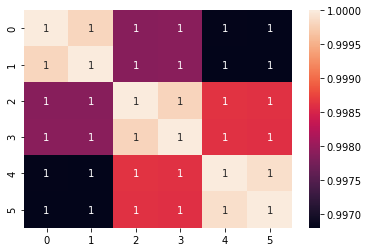

In [158]:
sns.heatmap(test_lv1.iloc[:,:].corr(), annot=True)
plt.show()

- So what this is saying is,XGBoost (models 0 and 1) is a bit closer to LightGBM (models 2 and 3) than to CatBoost (models 4 and 5), and LightGBM is closer to Catboost than to XGBoost.

What if we bring in the full stack's predictions?

In [161]:
stack_feature = pd.Series(test_preds, name='full_stack')
corr_compare = test_lv1.join(stack_feature)
corr_compare.head()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,0,1,2,3,4,5,full_stack
0,0.778917,0.783695,0.804150,0.798237,0.806537,0.818068,0.776622
1,0.348133,0.352351,0.386135,0.397379,0.365545,0.371936,0.374291
2,0.912121,0.914026,0.913147,0.912995,0.914974,0.914787,0.895940
3,0.813371,0.813845,0.875267,0.877467,0.871601,0.871644,0.797825
4,0.370489,0.365454,0.330845,0.319868,0.356576,0.360108,0.327939


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


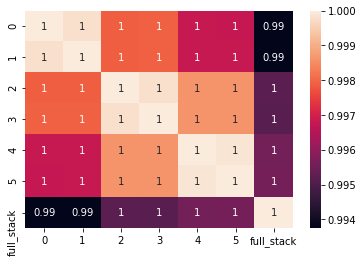

In [162]:
sns.heatmap(corr_compare.corr(), annot=True)
plt.show()

- So this is indicating that the stack is further apart from each of the GBMs than they are from one another -- but, it's marginally closer to CatBoost than to LightGBM, and it's definitely closer to both of those than to XGBoost alone. **So, wrt power averaging, it actually may not make sense to power average with CatBoost and LightGBM alongside the stack.** 

What if we bring in some `widedeep` predictions too?

In [163]:
widedeep_preds = load(predpath/'stacking_manual_20211012_194716_widedeep-TabMLP_5folds_rs1983_500epochs_test_preds.joblib')

In [164]:
type(widedeep_preds)

numpy.ndarray

In [166]:
widedeep_preds = pd.Series(widedeep_preds, name='widedeep_tabmlp1983')

In [168]:
corr_compare_deep = corr_compare.join(widedeep_preds)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [169]:
corr_compare_deep.head()

,0,1,2,3,4,5,full_stack,widedeep_tabmlp1983
0,0.778917,0.783695,0.804150,0.798237,0.806537,0.818068,0.776622,0.613051
1,0.348133,0.352351,0.386135,0.397379,0.365545,0.371936,0.374291,0.300757
2,0.912121,0.914026,0.913147,0.912995,0.914974,0.914787,0.895940,0.861658
3,0.813371,0.813845,0.875267,0.877467,0.871601,0.871644,0.797825,0.831054
4,0.370489,0.365454,0.330845,0.319868,0.356576,0.360108,0.327939,0.271750


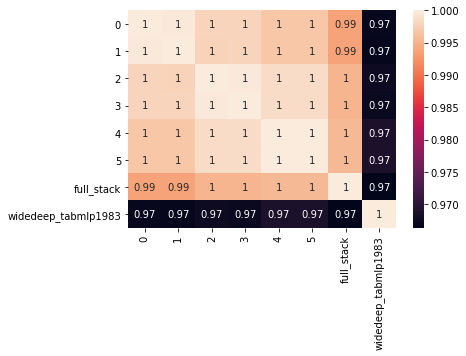

In [171]:
sns.heatmap(corr_compare_deep.corr(), annot=True)
plt.show()

## Modified Mix

In [178]:
mod_mix = 0.5*stack_preds + 0.4*test_lv1_xgb42 + 0.1*widedeep_preds

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [179]:
mod_mix[:10]

0    0.771276
1    0.371675
2    0.899395
3    0.832125
4    0.323482
5    0.298119
6    0.067020
7    0.420950
8    0.935404
9    0.863866
dtype: float64

In [180]:
sample_df = pd.read_csv(datapath/'sample_submission.csv.zip')

In [181]:
sample_df.loc[:, 'target'] = mod_mix

In [182]:
sample_df.head()

,id,target
0,1000000,0.771276
1,1000001,0.371675
2,1000002,0.899395
3,1000003,0.832125
4,1000004,0.323482


In [ ]:
# submission_path = datapath/'submissions'
# submission_path.mkdir(exist_ok=True)

In [183]:
sample_df.to_csv(subpath/f"{wandb_config['name']}_3level-GBM-0.5stack_0.4xgb42_0.1tabmlp1983_ensemble_preds.csv", index=False)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


## Mod Mix Two

In [194]:
mod_mix_two = 0.6*stack_preds + 0.2*test_lv1_xgb42 + 0.05*test_lv1_lgb42 + 0.05*test_lv1_cat42 + 0.1*widedeep_preds

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [195]:
mod_mix_two[:10]

0    0.767381
1    0.367561
2    0.897714
3    0.821103
4    0.326461
5    0.300912
6    0.071226
7    0.417652
8    0.931249
9    0.856340
dtype: float64

In [180]:
sample_df = pd.read_csv(datapath/'sample_submission.csv.zip')

In [196]:
sample_df.loc[:, 'target'] = mod_mix_two

In [197]:
sample_df.head()

,id,target
0,1000000,0.767381
1,1000001,0.367561
2,1000002,0.897714
3,1000003,0.821103
4,1000004,0.326461


In [ ]:
# submission_path = datapath/'submissions'
# submission_path.mkdir(exist_ok=True)

In [198]:
sample_df.to_csv(subpath/f"{wandb_config['name']}_3level-GBM-0.6stack_0.2xgb42_0.1tabmlp1983_0.05lgb42_0.05cat42_ensemble_preds.csv", index=False)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


## 4th power

In [187]:
power4_avg_alt = 0.5*stack_preds**4 + 0.4*test_lv1_xgb42 + 0.1*widedeep_preds** 4

In [188]:
power4_avg_alt[:20]

0     0.517675
1     0.165085
2     0.742554
3     0.600389
4     0.138666
5     0.123029
6     0.016651
7     0.194593
8     0.808226
9     0.665501
10    0.748593
11    0.324759
12    0.063100
13    0.162280
14    0.242314
15    0.149315
16    0.155302
17    0.254394
18    0.044736
19    0.816321
dtype: float64

In [189]:
sample_df = pd.read_csv(datapath/'sample_submission.csv.zip')

In [190]:
sample_df.loc[:, 'target'] = power4_avg_alt

In [191]:
sample_df.head()

,id,target
0,1000000,0.517675
1,1000001,0.165085
2,1000002,0.742554
3,1000003,0.600389
4,1000004,0.138666


In [192]:
# submission_path = datapath/'submissions'
# submission_path.mkdir(exist_ok=True)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [193]:
sample_df.to_csv(subpath/f"{wandb_config['name']}_3level-GBM-0.5stack_0.4xgb42_0.1tabmlp1983_pow-avg4_ensemble_preds.csv", index=False)

## 6th power

In [123]:
power6_avg = (stack_preds**6 + cat1983_preds**6 + lgb1983_preds**6) / 3

In [124]:
power6_avg[:20]

0     1.372567e-01
1     2.429774e-04
2     6.081943e-01
3     3.256891e-01
4     5.947037e-04
5     1.026115e-04
6     1.535337e-09
7     1.615576e-03
8     8.099990e-01
9     3.659600e-01
10    5.456658e-01
11    3.959378e-02
12    4.262004e-06
13    3.244684e-03
14    5.252903e-03
15    3.274883e-04
16    8.155606e-04
17    1.693755e-02
18    3.179565e-07
19    7.874945e-01
Name: target, dtype: float64

In [125]:
sample_df = pd.read_csv(datapath/'sample_submission.csv.zip')

In [126]:
sample_df.loc[:, 'target'] = power6_avg

In [127]:
sample_df.head()

,id,target
0,1000000,0.137257
1,1000001,0.000243
2,1000002,0.608194
3,1000003,0.325689
4,1000004,0.000595


In [128]:
# submission_path = datapath/'submissions'
# submission_path.mkdir(exist_ok=True)

In [129]:
sample_df.to_csv(subpath/f"{wandb_config['name']}_3level-GBM-stack_cat1983_lgb1983_pow-avg6_ensemble_preds.csv", index=False)

## 5th power

In [130]:
power5_avg = (stack_preds**5 + cat1983_preds**5 + lgb1983_preds**5) / 3

In [131]:
# power5_avg[:20]

In [132]:
sample_df = pd.read_csv(datapath/'sample_submission.csv.zip')

In [133]:
sample_df.loc[:, 'target'] = power5_avg

In [134]:
sample_df.head()

,id,target
0,1000000,0.190688
1,1000001,0.000956
2,1000002,0.660202
3,1000003,0.392404
4,1000004,0.002031


In [128]:
# submission_path = datapath/'submissions'
# submission_path.mkdir(exist_ok=True)

In [135]:
sample_df.to_csv(subpath/f"{wandb_config['name']}_3level-GBM-stack_cat1983_lgb1983_pow-avg5_ensemble_preds.csv", index=False)

## 3rd power

In [136]:
power3_avg = (stack_preds**3 + cat1983_preds**3 + lgb1983_preds**3) / 3

In [131]:
# power5_avg[:20]

In [137]:
sample_df = pd.read_csv(datapath/'sample_submission.csv.zip')

In [138]:
sample_df.loc[:, 'target'] = power3_avg

In [139]:
sample_df.head()

,id,target
0,1000000,0.369014
1,1000001,0.015117
2,1000002,0.778719
3,1000003,0.570054
4,1000004,0.023955


In [128]:
# submission_path = datapath/'submissions'
# submission_path.mkdir(exist_ok=True)

In [140]:
sample_df.to_csv(subpath/f"{wandb_config['name']}_3level-GBM-stack_cat1983_lgb1983_pow-avg3_ensemble_preds.csv", index=False)